# Préparation de l'espace de travail

## Importations

In [ ]:
import openpyxl 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from cartiflette import carti_download
import mapclassify

## Lecture des bases de données

### Base de la démographie des médecins : medecin

In [ ]:
# Lecture du Excel medecins 
df_medecins_effectif_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=1)
df_medecins_age_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=2)
df_medecins_densite_complet = pd.read_excel("Bases de données/demographie_medecins.xlsx", sheet_name=3)

In [ ]:
# Traitement de la feuille des effectifs : on ne conserve que les médecins généralistes et on enlève les variables pas pertinentes ou redondantes
df_medecins_effectif = df_medecins_effectif_complet[(df_medecins_effectif_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_effectif_complet['sexe'] == '0-Ensemble')
    & (df_medecins_effectif_complet['specialites'] == '00-Ensemble')
    ]

df_medecins_effectif.drop(axis = 1, columns = ['sexe', 'specialites', 'specialites_agregees'], inplace = True)
df_medecins_effectif.reset_index(drop = True, inplace = True)

df_medecins_effectif

In [ ]:
# Traitement de la feuille des âges moyens : on ne conserve que les médecins généralistes et on enlève les variables pas pertinentes ou redondantes
df_medecins_age = df_medecins_age_complet[(df_medecins_age_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_age_complet['sexe'] == '0-Ensemble')
    & (df_medecins_age_complet['specialites'] == '00-Ensemble')]

df_medecins_age.drop(axis = 1, columns = ['sexe', 'specialites', 'specialites_agregees'], inplace = True)
df_medecins_age.reset_index(drop = True, inplace = True)

df_medecins_age

In [ ]:
# Traitement de la feuille des densités : on ne conserve que les médecins généralistes et on enlève les variables pas pertinentes ou redondantes
df_medecins_densite = df_medecins_densite_complet[(df_medecins_densite_complet['specialites_agregees'] == '1-Médecine générale') 
    & (df_medecins_densite_complet['sexe'] == '0-Ensemble')
    & (df_medecins_densite_complet['specialites'] == '00-Ensemble')]

df_medecins_densite.drop(axis = 1, columns = ['sexe', 'specialites', 'specialites_agregees'], inplace = True)
df_medecins_densite.reset_index(drop = True, inplace = True)

df_medecins_densite

### Base de la prévalence de différentes maladies par groupe de population : santePublique

In [ ]:
# Lecture du csv santePublique
import zipfile

with zipfile.ZipFile("Bases de données/santePublique.zip", 'r') as zip_ref:
    zip_ref.extractall("Bases de données")

df_sante_publique = pd.read_csv('Bases de données/santePublique.csv', sep=";")

### Base de l'indicateur APL (Accessibilité Potentielle Localisée) pour les médecins généralistes 

In [ ]:
# Lecture du Excel APL_2022_2023 : tableau de la pondération de la population
# (consommation moyenne en soins de la tranche d'âge rapportée à la consommation moyenne de la population)
df_pond_population_2022_2023 = pd.read_excel("Bases de données/APL_2022_2023.xlsx", sheet_name=0)[21:40]
df_pond_population_2022_2023.reset_index(drop=True, inplace=True)

# Renommage des colonnes
df_pond_population_2022_2023.columns = ["Tranche d'âge", "Poids de la tranche d'âge en 2022", "Poids de la tranche d'âge en 2023"]

# Lecture du Excel APL_2015_2022 : tableau de pondération de la population (on exclut l'année 2022 en supposant que les données de APL_2022_2023 sont plus pertinentes)
df_pond_population_2015_2021 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=0)[21:40]
df_pond_population_2015_2021.reset_index(drop=True, inplace=True)

# Renommage des colonnes
df_pond_population_2015_2021.columns = ["Tranche d'âge", "Poids de la tranche d'âge en 2015", "Poids de la tranche d'âge en 2016", "Poids de la tranche d'âge en 2017", 
    "Poids de la tranche d'âge en 2018", "Poids de la tranche d'âge en 2019", "Poids de la tranche d'âge en 2021", "Poids de la tranche d'âge en 2022 bis"]
df_pond_population_2015_2021.drop("Poids de la tranche d'âge en 2022 bis", axis=1, inplace=True)

# Merging des deux tables sur la clé de la tranche d'âge
df_pond_population = df_pond_population_2015_2021.merge(right=df_pond_population_2022_2023, how="left", on=["Tranche d'âge"])

df_pond_population

In [ ]:
# Lecture des deux feuilles de la table APL_2022_2023
df_APL_2022 = pd.read_excel("Bases de données/APL_2022_2023.xlsx", sheet_name=1)[8:]
df_APL_2023 = pd.read_excel("Bases de données/APL_2022_2023.xlsx", sheet_name=2)[8:]

# Nettoyage et renommage des colonnes
bases = [df_APL_2022, df_APL_2023]
annee = 2022

for base in bases : 
    base.drop(8,inplace=True)
    base.reset_index(drop=True, inplace=True)
    base.columns = ["Code commune INSEE", "Commune", f"APL_{annee}", f"APL_{annee}_moins_65", f"APL_{annee}_moins_62", f"APL_{annee}_moins_60", f"population_standard_{annee-2}", f"population_totale_{annee-2}"]
    annee += 1

# Lecture des feuilles de la table APL_2015_2022 (on exclut l'année 2022 en supposant que les données de APL_2022_2023 sont plus pertinentes)
df_APL_2015 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=1)[8:]
df_APL_2016 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=2)[8:]
df_APL_2017 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=3)[8:]
df_APL_2018 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=4)[8:]
df_APL_2019 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=5)[8:]
df_APL_2021 = pd.read_excel("Bases de données/APL_2015_2022.xlsx", sheet_name=6)[8:]

# Nettoyage et renommage des colonnes
bases = [df_APL_2015,df_APL_2016,df_APL_2017,df_APL_2018,df_APL_2019,df_APL_2021]
annee = 2015

for base in bases : 
    base.drop(8,inplace=True)
    base.reset_index(drop=True, inplace=True)
    base.columns = ["Code commune INSEE", "Commune", f"APL_{annee}", f"APL_{annee}_moins_65", f"population_standard_{annee-2}", f"population_totale_{annee-2}"]
    annee += 1
    if annee == 2020 : 
        annee += 1

bases.append(df_APL_2022)
df_APL = df_APL_2023
for base in bases : 
    df_APL = df_APL.merge(base, how='left', on=["Code commune INSEE", "Commune"])

df_APL['departement'] = df_APL['Code commune INSEE'].astype(str).str[:2]

In [ ]:
# On crée l'indicateur  APL par département pour l'année 2023
df_APL["APL_2023"] = pd.to_numeric(df_APL["APL_2023"], errors="coerce")

df_APL['APL_2023_pond'] = df_APL['APL_2023'] * df_APL['population_standard_2021']
df_APL["APL_dep_2023"] = df_APL.groupby("departement")['APL_2023_pond'].transform("mean")

df_APL["APL_dep_2023"] = pd.to_numeric(df_APL["APL_dep_2023"], errors="coerce")

### Base du nombre de médecins généralistes par commune (2025)

In [ ]:
df_freq_medecins_commune = pd.read_excel("Bases de données/medecins_commune_2025.xlsx")[4:]
df_freq_medecins_commune.reset_index(drop=True, inplace=True)
df_freq_medecins_commune.columns = ["Code commune INSEE", "Commune", "Médecins généralistes en 2025"]

df_freq_medecins_commune

### Base de la patientèle des médecins 

In [ ]:
df_patientele = pd.read_csv("Bases de données/patientele.csv", sep=";")

# Enlever les caractères cachés dans le nom des colonnes (provoquaient des bugs dans la suite du code)
df_patientele.columns = df_patientele.columns.str.replace('\ufeff', '').str.strip()

df_patientele["nombre_patients_uniques"] = pd.to_numeric(df_patientele["nombre_patients_uniques"], errors="coerce")
df_patientele['profession_sante'].unique()

### Base de la population des communes

In [ ]:
df_pop_communes = pd.read_excel("Bases de données/POPULATION_MUNICIPALE_COMMUNES_FRANCE.xlsx")
df_pop_communes

# Premières visualisations des bases

## Base de la démographie des médecins

### Evolution du nombre de généralistes en France

In [ ]:
# Définition de la base de données réduite 
df_cond = df_medecins_effectif[(df_medecins_effectif['exercice']=='0-Ensemble') 
    & (df_medecins_effectif['tranche_age']=='00-Ensemble') 
    & (df_medecins_effectif['region'] == '00-Ensemble') 
    & (df_medecins_effectif['territoire'] == "0-France entière")] 
df = df_cond.copy()

# Définition des abscisses : années 2012 à 2025 
annees = list(range(2012,2026)) 

# Définition des ordonnées : effectifs des années 2012 à 2025 
effectifs = df[[f"effectif_{a}" for a in annees]].values.flatten() 
plt.plot(annees, effectifs, marker = "o") 

# Affichage du graphique 
plt.ylabel("Nombre de médecins généralistes") 
plt.title("Évolution du nombre de médecins généralistes en France") 

# Sous-texte
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : Le nombre de médecins généralistes en France est passé d'environ 101 500 en 2012 à 100 000 en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

### Evolution du nombre de généralistes par région

In [ ]:
# Définition de la base de données réduite 
df_cond = df_medecins_effectif[(df_medecins_effectif['exercice']=='0-Ensemble') & (df_medecins_effectif['tranche_age']=='00-Ensemble') & (df_medecins_effectif['region'] != '00-Ensemble')]
df = df_cond.copy()

# Définition des abscisses : années 2012 à 2025 
annees = list(range(2012,2026))

# Définition des ordonnées : effectifs par région des années 2012 à 2025 
for region in df['region'].unique() :
    df_region = df[(df['region'] == region) & (df['departement'] == '000-Ensemble')]
    effectifs = df_region[[f"effectif_{a}" for a in annees]].values.flatten()
    plt.plot(annees, effectifs, label = region, marker = "o")

# Affichage du graphique 
plt.xlabel("Année")
plt.ylabel("Nombre de médecins généralistes")
plt.title(f"Évolution du nombre de médecins généralistes par région")

# Légende
plt.legend(title="Région", bbox_to_anchor=(1.05, 1), loc="upper left")

# Sous-texte
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes par région en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : Le nombre de médecins généralistes en Île de France est passé d'environ 18 500 en 2012 à 16 000 en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

### Evolution de l'âge moyen des généralistes en France

In [ ]:
# Définition de la base de données réduite 
df_cond = df_medecins_age[(df_medecins_age['exercice']=='0-Ensemble') 
    & (df_medecins_age['region'] == '00-Ensemble') 
    & (df_medecins_age['territoire'] == "0-France entière")] 
df = df_cond.copy()

# Définition des abscisses : années 2012 à 2025 
annees = list(range(2012,2026)) 


# Définition des ordonnées : effectifs des années 2012 à 2025 
effectifs = df[[f"am_{a}" for a in annees]].values.flatten() 
plt.plot(annees, effectifs, marker = "o") 

# Affichage du graphique plt.xlabel("Année") 
plt.ylabel("Âge moyen des médecins généralistes") 
plt.title("Évolution de l'âge moyen des médecins généralistes en France") 
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : L'âge moyen des médecins généralistes en France est passé de 51,1 ans en 2012 à 50,4 ans en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

### Evolution du nombre de médecins généralistes par tranche d'âge en France

In [ ]:
# Définition de la base de données réduite 
df_cond = df_medecins_effectif[(df_medecins_effectif['exercice']=='0-Ensemble') 
    & (df_medecins_effectif['region'] == '00-Ensemble') 
    & (df_medecins_effectif['territoire'] == "0-France entière")
    & (df_medecins_effectif['tranche_age'] != "00-Ensemble")] 
df = df_cond.copy()

# Définition des abscisses : années 2012 à 2025 
annees = list(range(2012,2026)) 

# Définition des ordonnées : effectifs par tranche des années 2012 à 2025 
for tranche in df['tranche_age'].unique() : 
    df_age = df[df['tranche_age'] == tranche]
    effectifs = df_age[[f"effectif_{a}" for a in annees]].values.flatten() 
    plt.plot(annees, effectifs, label = tranche, marker = "o") 

# Affichage du graphique 
plt.ylabel("Nombre de médecins généralistes") 
plt.title("Évolution du nombre de médecins généralistes par tranche d'âge en France") 

# Légende
plt.legend(title="Tranche d'âge", bbox_to_anchor=(1.05, 1), loc="upper left")

# Sous-texte
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : Le nombre de médecins généralistes entre 55 et 59 ans en France est passé d'environ 19 000 en 2012 à 10 000 en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

### Evolution de la proportion des médecins généralistes par tranche d'âge en France

In [ ]:
# Définition de la base de données réduite 
df_cond = df_medecins_effectif[(df_medecins_effectif['exercice']=='0-Ensemble') 
    & (df_medecins_effectif['region'] == '00-Ensemble') 
    & (df_medecins_effectif['territoire'] == "0-France entière")] 
df = df_cond.copy()

# Définition des abscisses : années 2012 à 2025 
annees = list(range(2012,2026)) 

# Définition de nouvelles variables proportion par année
for annee in annees:
    total = df.loc[df['tranche_age'] == '00-Ensemble', f'effectif_{annee}'].values[0]
    df[f'proportion_{annee}'] = df[f'effectif_{annee}'] / total

# Définition des nuances de couleurs
cmap = cm.get_cmap("OrRd")
colors = cmap(np.linspace(0, 1, 12))
i = 0

# Définition des ordonnées : proportion des tranches des années 2012 à 2025 
for tranche in df['tranche_age'].unique() : 
    if tranche != "00-Ensemble" :
        df_age = df[df['tranche_age'] == tranche]
        proportion = df_age[[f"proportion_{a}" for a in annees]].values.flatten()
        plt.plot(annees, proportion, label = tranche, marker = "o", color = colors[i]) 
        i += 1

# Affichage du graphique 
plt.ylabel("Proportion des médecins généralistes") 
plt.title("Évolution de la proportion de médecins généralistes par tranche d'âge en France") 

# Légende
plt.legend(title="Tranche d'âge", bbox_to_anchor=(1.05, 1), loc="upper left")

# Sous-texte
plt.text(0, -0.16, "Source : DREES (RPPS), La démographie des professionnels de santé depuis 2012.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.21, "Champ : Médecins généralistes en France, DROM inclus.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 
plt.text(0, -0.26, "Lecture : La proportion de médecins généralistes entre 30 et 34 ans en France est passée de 0.06 en 2012 à 0.125 en 2025.", ha="left", va="bottom", fontsize=9, transform=plt.gca().transAxes) 

plt.grid(True)
plt.show()

### Etude de la densité de médecin par département pour l'année 2023

In [ ]:
df = df_medecins_densite.copy()
df = df[(df['departement'] != '000-Ensemble') 
    & (df['tranche_age'] == '00-Ensemble')
    & (df['exercice'] == '0-Ensemble')]

df.reset_index(inplace = True, drop = True)

df['departement'] = df['departement'].astype(str).str[:3]

# Départements

departements = carti_download(
    values = ["France"],
    crs = 4326,
    borders = "DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

departements['INSEE_DEP'] = departements['INSEE_DEP'].str.zfill(3)

# Test d'affichage de la carte
departements.plot().axis('off')

In [ ]:
# On joint les deux bases
departements = departements.merge(df, left_on = "INSEE_DEP", right_on = "departement", how="left")
departements = departements.to_crs(2154)

departements

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

departements.plot(
    ax=ax,
    column="densite_2023",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
)

ax.axis("off")
ax.set_title("Densité de médecins par département en 2023", fontsize=14)

plt.show()

## Base de l'indicateur APL

### Etude de l'indicateur APL par commune/département pour l'année 2023

In [ ]:
df_APL['APL_2023'].dropna().describe()
df_APL['APL_dep_2023'].dropna().describe()

### Cartographie de l'indicateur APL par commune pour l'année 2023

In [ ]:
df = df_APL.copy()
departements = df_APL['departement'].unique()

# 1. Communes
communes = carti_download(
    values = departements,
    crs = 4326,
    borders="COMMUNE_ARRONDISSEMENT",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

# 2. Départements 
departements = communes.dissolve("INSEE_DEP")

communes = communes.merge(df, left_on = "INSEE_COG", right_on = "Code commune INSEE", how="left")
communes = communes.to_crs(2154)

In [ ]:
communes.plot()

In [ ]:
# Réalisation de la carte
fig, ax = plt.subplots(figsize=(10,10))

communes.plot(
    ax=ax,
    column="APL_2023",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
    scheme = "quantiles",
    k = 10, 
    legend_kwds={"labels": [i for i in range(10)]},
    missing_kwds={"color": "lightgrey", "label": "Données manquantes"}
)

ax.axis("off")
ax.set_title("Indicateur APL par commune en 2023", fontsize=14)

q10 = mapclassify.Quantiles(communes['APL_2023'].dropna(), k=15)
mapping = {i: s for i, s in enumerate(q10.get_legend_classes())}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), mapping)

plt.show()

### Création de l'indicateur APL par département

In [ ]:
# Départements

departements = carti_download(
    values = ["France"],
    crs = 4326,
    borders = "DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Test d'affichage de la carte
departements.plot().axis('off')

In [ ]:
# On crée une copie de la table
df = df_APL.copy()

# On refait une carte, cette fois-ci des départements
df.drop_duplicates('departement', inplace = True)
departements = departements.merge(df, left_on = "INSEE_DEP", right_on = "departement", how="left")
departements = departements.to_crs(2154)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

departements.plot(
    ax=ax,
    column="APL_dep_2023",
    cmap="OrRd",               
    linewidth=0,
    edgecolor="lightgrey",
    legend=True,
    scheme = "quantiles",
    k = 10, 
    legend_kwds={"labels": [i for i in range(10)]},
    missing_kwds={"color": "lightgrey", "label": "Données manquantes"}
)

ax.axis("off")
ax.set_title("Indicateur APL par département en 2023", fontsize=14)

q10 = mapclassify.Quantiles(departements['APL_dep_2023'].dropna(), k=10)
mapping = {i: s for i, s in enumerate(q10.get_legend_classes())}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), mapping)

plt.show()

In [ ]:
departements["APL_dep_2023_log"] = np.log1p(departements["APL_dep_2023"])

fig, ax = plt.subplots(figsize=(10,10))

departements.plot(
    ax=ax,
    column="APL_dep_2023_log",
    cmap="OrRd",               
    linewidth=0,
    legend=True,
    edgecolor="lightgrey", 
)

ax.axis("off")
ax.set_title("Indicateur APL logarithmique par département en 2023", fontsize=14)

plt.show()

## Base de la patientèle (nombre de patients uniques par médecin) - pas pertinent, base trop petite ?

### Etude du nombre moyen de patients par médecin en 2017

In [ ]:
# On s'intéresse d'abord uniquement à l'année 2017
df = df_patientele.copy()
df = df[(df['annee'] == 2017) & (df['profession_sante'] == 'Ensemble des médecins généralistes')]
df['nombre_patients_uniques'].describe()

df['moyenne_patientele_2017'] = df.groupby('departement')['nombre_patients_uniques'].transform('mean')

In [ ]:
# Départements
departements = carti_download(
    values = ["France"],
    crs = 4326,
    borders = "DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Test d'affichage de la carte
departements.plot().axis('off')
departements['INSEE_DEP'].unique()

In [ ]:
# On refait une carte, cette fois-ci des départements

df.drop_duplicates('departement', inplace = True)
departements = departements.merge(df, left_on = "INSEE_DEP", right_on = "departement", how="left")
departements = departements.to_crs(2154)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

departements.plot(
    ax=ax,
    column="moyenne_patientele_2017",
    cmap="OrRd",               
    linewidth=0.05,
    legend=True,
    edgecolor="lightgrey", 
)

ax.axis("off")
ax.set_title("Nombre moyen de patiens par médecin en 2017", fontsize=14)

plt.show()

## Corrélation entre densité et APL

### Premier test uniquement sur l'année 2023

In [ ]:
# On réarrange les tables APL densités de médecins
df1 = df_APL.copy()
df1['departement'] = df1['departement'].str.zfill(3)
df.drop_duplicates('departement', inplace = True)

df2 = df_medecins_densite.copy()
df2 = df2[(df2['departement'] != '000-Ensemble') 
    & (df2['tranche_age'] == '00-Ensemble')
    & (df2['exercice'] == '0-Ensemble')]
df2['departement'] = df2['departement'].astype(str).str[:3]

df = df1.merge(df2, on = 'departement')
df.reset_index(drop = True, inplace = True)

df['APL_dep_2023']

In [ ]:
sns.regplot(
    data = df,
    x = 'densite_2023',
    y = 'APL_dep_2023',
    fit_reg = True,
    scatter_kws={'alpha':0.5}
)

### On étend la régression aux années pour lesquelles on a des données : 2015 à 2023, 2020 exclu

In [ ]:
# On réarrange les tables APL densités de médecins
df1 = df_APL.copy()
df1['departement'] = df1['departement'].str.zfill(3)

df2 = df_medecins_densite.copy()
df2 = df2[(df2['departement'] != '000-Ensemble') 
    & (df2['tranche_age'] == '00-Ensemble')
    & (df2['exercice'] == '0-Ensemble')]
df2['departement'] = df2['departement'].astype(str).str[:3]

# On crée l'indicateur  APL par département pour les années 2015 à 2022, 2020 exclu
annees = [2015, 2016, 2017, 2018, 2019, 2021, 2022]

for annee in annees : 
    df1[f"APL_{annee}"] = pd.to_numeric(df1[f"APL_{annee}"], errors="coerce")
    df1[f'APL_{annee}_pond'] = df1[f'APL_{annee}'] * df1[f'population_standard_{annee - 2}']

    df1[f"APL_dep_{annee}"] = df1.groupby("departement")[f'APL_{annee}_pond'].transform("mean")
    df1[f"APL_dep_{annee}"] = pd.to_numeric(df1[f"APL_dep_{annee}"], errors="coerce")

df1.drop_duplicates('departement', inplace = True)

In [149]:
# On transforme les tables larges en tables longues de manière à pouvoir faire la régression en utilisant les données de toutes les années
annees = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]
APL = [f"APL_dep_{annee}" for annee in annees]
densite = [f"densite_{annee}" for annee in annees] 

# Pour l'APL
df1_long = df1.melt(
    id_vars = ['departement'], 
    value_vars = APL, 
    var_name = 'annee',
    value_name = 'APL'
)

df1_long['annee'] = df1_long['annee'].astype(str).str[8:]

# Pour la densité
df2_long = df2.melt(
    id_vars = ['departement'], 
    value_vars = densite, 
    var_name = 'annee',
    value_name = 'densite' 
)

df2_long['annee'] = df2_long['annee'].astype(str).str[8:]

# On joint les deux tables
df = pd.merge(df2_long, df1_long, on=['departement', 'annee'])
df['APL'] = np.log(df['APL'])

df

,departement,annee,densite,APL
0,075,2015,247.32,11.473948
1,077,2015,105.53,8.967691
2,078,2015,128.85,9.693680
3,091,2015,124.90,9.820391
4,092,2015,162.28,11.836078
...,...,...,...,...
763,013,2023,175.66,11.164242
764,083,2023,151.49,10.262433
765,084,2023,144.80,9.536086
766,02A,2023,156.88,8.572286


<Axes: xlabel='densite', ylabel='APL'>

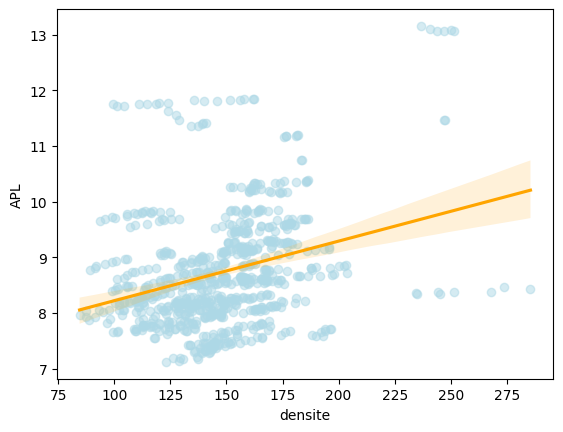

In [161]:
# Régression utilisant les données toutes années confondues
sns.regplot(
    data = df,
    x = 'densite',
    y = 'APL',
    fit_reg = True,
    scatter_kws={'alpha':0.5},
    color="lightblue", line_kws=dict(color="orange")
)